In [12]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import patches
from IPython.display import Image
import pandas as pd
from skimage import exposure
from scipy import signal
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from skimage import color
from skimage import io
from skimage import feature
from skimage import morphology
from skimage import util

import copy

from scipy.signal import fftconvolve

%load_ext autoreload
%autoreload 2
from p2Helpers import importImgs
from p2Helpers import showImgs
from p2Helpers import findTemplateLocation
from p2Helpers import getTemplates
from p2Helpers import plotImgAndTemplate
from p2Helpers import plot3dcorr

from itertools import combinations

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Helper Functions

In [13]:
# See p2Helpers.py

def printSeparator():
    print("\n\n\n\n================================================================================================================"\
          "\n================================================================================================================"\
         "\n================================================================================================================"\
         "\n================================================================================================================")
    

## Sub-region Helper Functions 

In [14]:
def topLeftOfTemplate(i,j,xb,yb,tw,th):
    x = xb - (i*tw)
    y = yb - (j*th)

    return x,y

def finalScore(scoresNew): # using count
    scoresFinal = []
    maxCount = 0
    maxIdx = -1
    for bi,b in enumerate(scoresNew):
        if(b[2] > maxCount):
            maxCount = b[2]
            maxIdx = bi
    if (maxIdx != -1):
        return scoresNew[maxIdx]
    else:
        return -1

def finalScoreUsingScore(scoresNew):
    scoresFinal = []
    maxScore = 0
    maxIdx = -1
    for bi,b in enumerate(scoresNew):
        if(b[1] > maxScore):
            maxScore = b[1]
            maxIdx = bi
    if (maxIdx != -1):
        return scoresNew[maxIdx]
    else:
        return [-1]    
    
def combineBestScores(scores, tol = 2):
    scoresNew = []
    for bi,b in enumerate(scores):
        s = b[0] # location for this score
        x = s[0]
        y = s[1]
        # first time through just set the first entry to the first score
        if bi == 0:
            scoresNew.append([[x,y], b[1], 1])
            continue
        # check for matching location
        found = 0
        for bni,bn in enumerate(scoresNew):
            # check for other instances of this location already found
            sn = bn[0] # location for this score
            xn = sn[0]
            yn = sn[1]
            if (x < xn+tol) and (x > xn-tol) and (y < yn+tol) and (y > yn-tol):
                scoresNew[bni] = [[xn,yn], bn[1]+b[1], bn[2]+1]
                found = 1
                break
        if not(found):
            scoresNew.append([[x,y], b[1], 1])

    return finalScore(scoresNew)

# Given 2 images, return best template image that can be found in both (if any)
def chooseTemplates(imgA, imgB): 
    DBG = 0
    # Factor by which to split image in each dimension
    # Try this factor first, can increase if no matches found
    tileFact = 4

    bestScores = []
    tileWidth = imgA.shape[0]//tileFact
    tileHeight = imgA.shape[1]//tileFact
    if DBG:
        print("Template shape", tileWidth,"x", tileHeight)

    # For each tile
    for i in range(0,tileFact,1):
        for j in range(0,tileFact,1):
            if DBG:
                print("Tile i=",i," j=",j)
            # Top left corner
            xb = i*tileWidth
            yb = j*tileHeight
            # Right bottom corner
            xf = (i+1)*tileWidth - 1
            yf = (j+1)*tileHeight - 1
            if DBG:
                print("Tile corners", xb, xf, yb, yf)
            _,x1,x2,y1,y2,score,corr,_ = findTemplateLocation(imgB,imgA[xb:xf,yb:yf])
            if (score != -1):
                bestScores.append([(x1,y1), corr, x2-x1,y2-y1])

                
        if DBG:
            print(bestScores)
            
        # Using raw correlation value as score
        # Should filter results to remove templates which are too small
        finalScore = finalScoreUsingScore(bestScores)
        if DBG:
            print("Best result:",finalScore)
        
    if(len(finalScore) > 1):
        p = finalScore[0]
        if DBG:
            print(p[0],p[1],finalScore[2],finalScore[3])
        return imgB[p[0]:p[0]+finalScore[2],p[1]:p[1]+finalScore[3]]
    else:
        return [-1]
        
        
def generateTemplates(path, files):
    finalTemplates = []
    templateNames = []
    imgs = importImgs(path,files)
    pairsName = ["".join(map(str, comb)) for comb in combinations(files, 2)]
    idx = 0
    for imPair in combinations(imgs, 2):
        bestTmpl = chooseTemplates(imPair[0],imPair[1])
        if(len(bestTmpl) > 1):
            finalTemplates.append(bestTmpl)
            templateNames.append("tmpl" + pairsName[idx])
#             io.imsave(path + "tmpl" + pairsName[idx] + '.tif', bestTmpl)
        idx = idx + 1
    
    return finalTemplates, templateNames

## Finding templates and contructing img-template table

In [15]:
imgList = [ \
            ["DS/1/",["A","B","C","D"]], \
            ["DS/2/21/",["E","F","G","H","I"]], \
            ["DS/2/22/",["J","K","L","M","N"]], \
            ["DS/2/23/",["O","P","Q","R","S"]], \
            ["DS/3/",["1","2","3","4","5"]]
           ]





Images: 
['A', 'B', 'C', 'D']


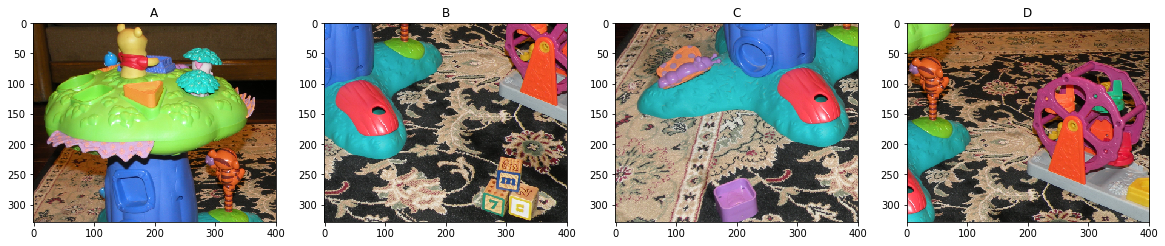

Templates: 
['tmplAB', 'tmplAD', 'tmplBC', 'tmplBD', 'tmplCD']


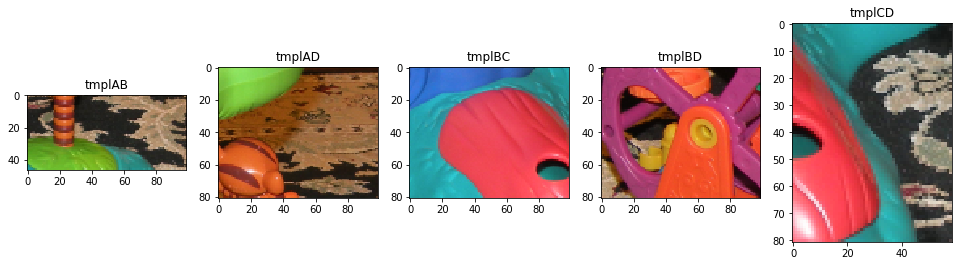

tmplAB      tmplAD     tmplBC      tmplBD     tmplCD
A  (280, 300)  (164, 300)        UNK         UNK        UNK
B    (0, 110)         UNK    (82, 0)    (1, 301)  (102, 90)
C         UNK         UNK  (62, 250)         UNK  (82, 340)
D   (130, 20)    (13, 19)        UNK  (130, 210)   (232, 0)

tmplAB   tmplAD  tmplBC   tmplBD   tmplCD
A        0  260.705     Inf      Inf      Inf
B        0      Inf  79.102  166.189  165.403
C      Inf      Inf       0      Inf        0
D  184.404        0     Inf        0        0





Images: 
['E', 'F', 'G', 'H', 'I']


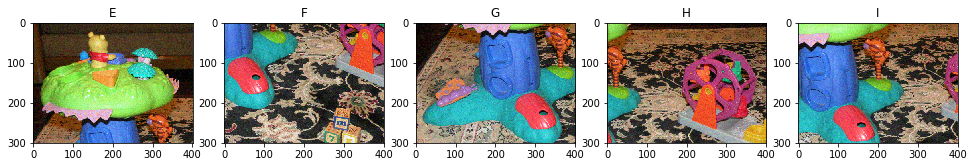

Templates: 
['tmplEG', 'tmplEH', 'tmplEI', 'tmplFH', 'tmplFI', 'tmplGH', 'tmplGI', 'tmplHI']


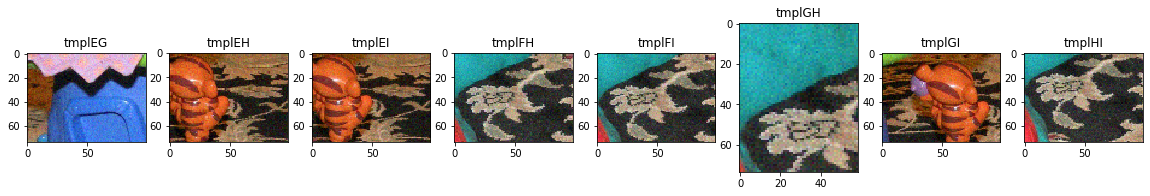

tmplEG      tmplEH      tmplEI      tmplFH      tmplFI      tmplGH  \
E  (225, 100)  (225, 301)  (225, 300)         UNK         UNK         UNK   
F         UNK         UNK         UNK   (75, 101)   (75, 100)   (60, 101)   
G    (5, 140)    (4, 340)    (5, 339)  (165, 340)  (165, 339)  (150, 340)   
H         UNK     (54, 0)     (55, 0)    (215, 0)    (215, 0)    (200, 0)   
I     (35, 0)   (34, 180)   (35, 179)  (195, 180)  (195, 179)  (180, 180)   

       tmplGI      tmplHI  
E  (220, 261)         UNK  
F         UNK   (85, 101)  
G    (0, 300)  (175, 340)  
H     (50, 0)    (225, 0)  
I   (30, 140)  (205, 180)

tmplEG   tmplEH   tmplEI   tmplFH   tmplFI   tmplGH   tmplGI   tmplHI
E  340.097  439.646  342.632      Inf      Inf      Inf  340.465      Inf
F      Inf      Inf      Inf  454.997  350.315   252.25      Inf  357.432
G        0  168.164  212.041   164.59  213.923  162.712  342.055  219.664
H      Inf        0  347.737        0  349.765        0  202.534  358.819
I  235.414  347.668        0  349.765        0  200.458        0        0





Images: 
['J', 'K', 'L', 'M', 'N']


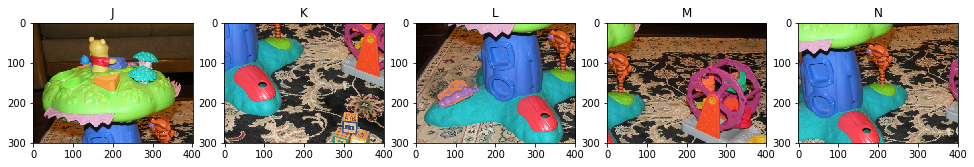

Templates: 
['tmplJL', 'tmplJN', 'tmplKL', 'tmplKN', 'tmplLM', 'tmplLN']


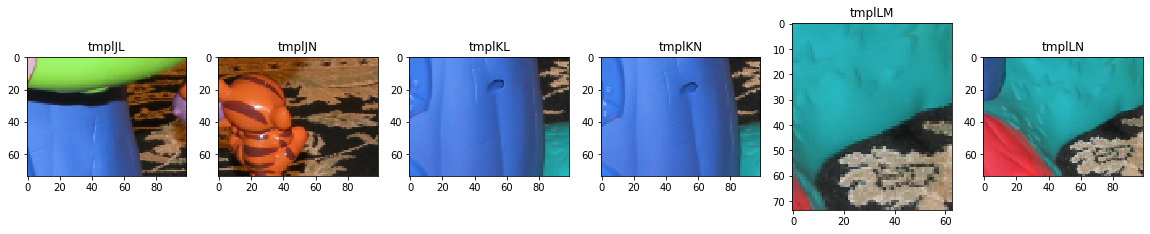

tmplJL      tmplJN     tmplKL     tmplKN      tmplLM      tmplLN
J  (225, 200)  (225, 300)        UNK        UNK         UNK         UNK
K         UNK         UNK     (0, 0)     (0, 0)         UNK    (69, 73)
L    (2, 241)         UNK  (78, 234)  (78, 233)  (150, 336)  (150, 300)
M         UNK         UNK        UNK        UNK    (208, 0)         UNK
N    (39, 82)   (39, 182)  (115, 77)  (115, 76)  (185, 184)  (185, 148)

tmplJL   tmplJN   tmplKL   tmplKN   tmplLM   tmplLN
J  242.793  175.746      Inf      Inf      Inf      Inf
K      Inf      Inf   154.83  48.5852      Inf  145.667
L        0      Inf        0  130.107  93.4161  260.219
M      Inf      Inf      Inf      Inf        0      Inf
N  336.282        0  128.884        0  194.904        0





Images: 
['O', 'P', 'Q', 'R', 'S']


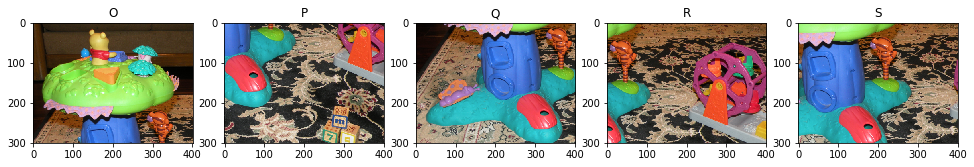

Templates: 
['tmplOQ', 'tmplOR', 'tmplOS', 'tmplPQ', 'tmplPR', 'tmplPS', 'tmplQR', 'tmplQS', 'tmplRS']


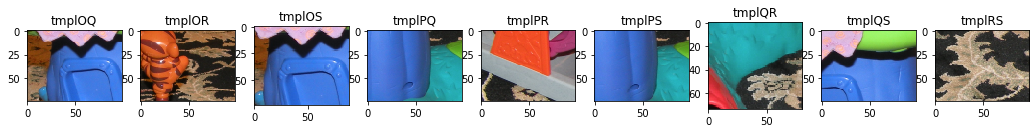

tmplOQ      tmplOR      tmplOS      tmplPQ      tmplPR      tmplPS  \
O  (225, 100)  (225, 300)  (225, 110)         UNK         UNK         UNK   
P         UNK         UNK         UNK      (0, 0)   (75, 300)      (0, 0)   
Q   (17, 142)         UNK   (17, 152)   (99, 248)         UNK   (99, 248)   
R         UNK    (49, 23)         UNK         UNK  (209, 231)         UNK   
S         UNK   (42, 197)     (41, 0)  (127, 102)         UNK  (127, 102)   

       tmplQR      tmplQS      tmplRS  
O         UNK  (208, 158)         UNK  
P    (54, 71)         UNK   (91, 170)  
Q  (150, 318)    (0, 200)         UNK  
R    (188, 0)         UNK  (225, 100)  
S  (183, 174)    (24, 49)  (220, 275)

tmplOQ   tmplOR   tmplOS   tmplPQ   tmplPR   tmplPS   tmplQR   tmplQS  \
O  114.22  385.645  194.584      Inf      Inf      Inf      Inf  148.359   
P     Inf      Inf      Inf  90.5352  76.2385  59.3231  62.1757      Inf   
Q       0      Inf  229.732        0      Inf  123.628  182.056   166.57   
R     Inf        0      Inf      Inf        0      Inf        0      Inf   
S     Inf  210.221        0  123.628      Inf        0  82.9441        0   

    tmplRS  
O      Inf  
P  307.029  
Q      Inf  
R  163.709  
S        0





Images: 
['1', '2', '3', '4', '5']


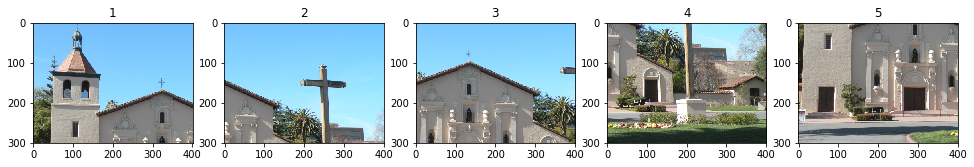

Templates: 
['tmpl12', 'tmpl13', 'tmpl15', 'tmpl23', 'tmpl24', 'tmpl25', 'tmpl34', 'tmpl35']


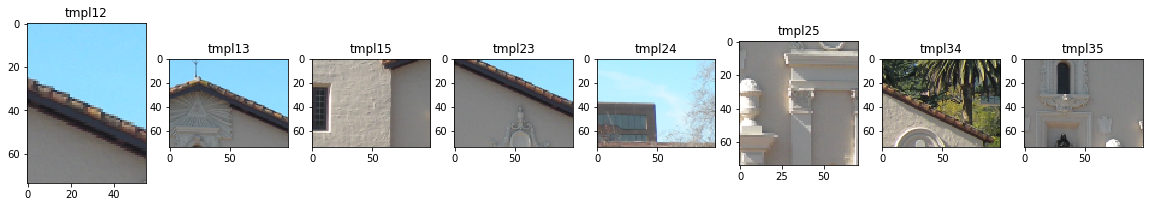

tmpl12      tmpl13      tmpl15      tmpl23      tmpl24      tmpl25  \
1  (157, 360)  (150, 300)  (225, 100)         UNK         UNK         UNK   
2    (117, 0)         UNK         UNK    (150, 0)  (225, 300)    (225, 0)   
3   (87, 170)   (80, 110)         UNK  (119, 169)         UNK  (195, 169)   
4         UNK         UNK         UNK         UNK   (25, 250)         UNK   
5         UNK         UNK     (5, 69)         UNK         UNK   (45, 329)   

       tmpl34      tmpl35  
1         UNK  (220, 291)  
2  (256, 130)         UNK  
3  (225, 300)  (150, 100)  
4    (55, 80)         UNK  
5         UNK    (0, 260)

tmpl12   tmpl13   tmpl15   tmpl23   tmpl24   tmpl25   tmpl34   tmpl35
1        0  109.409  71.8219      Inf      Inf      Inf      Inf   57.993
2        0      Inf      Inf  83.6601  127.968   71.897  294.804      Inf
3  39.7142        0      Inf        0      Inf  68.8638        0  56.8681
4      Inf      Inf      Inf      Inf        0      Inf        0      Inf
5      Inf      Inf        0      Inf      Inf        0      Inf        0

In [16]:
plotDBG = 0
imgTemplateTable = []
allImgs = {}
scoreTables = []
'''
imgNames : Holds a list of img names (e.g. ["A","B","C","D"])
imgPath : Has the corresponding path of imgNames
'''
for imgPath,imgNames in imgList:
    printSeparator()
    
    # Import imgs ===========================================================================
    print("Images: ")
    print(imgNames)
    inputImgs = importImgs(imgPath,imgNames)
    showImgs(inputImgs,imgNames)
    
    # Get Templates... ===========================================================================    
    templates,templateNames = generateTemplates(imgPath,imgNames)
    print("Templates: ")
    print(templateNames)
    showImgs(templates,templateNames)
    
    # Create template location table =============================================================
    tLocationTable = [["UNK" for i in range(len(templates))] for j in range(len(inputImgs))]
    sTable = [["Inf" for i in range(len(templates))] for j in range(len(inputImgs))]
    
    # Fill out the table
    for imgIdx, img in enumerate(inputImgs):
        allImgs[imgNames[imgIdx]] = img
        for templateIdx, template in enumerate(templates):
            cp,xb,xf,yb,yf,score,maxCorr,cMatrix = findTemplateLocation(img,template)
            
            if cp != -1:
                tLocationTable[imgIdx][templateIdx] = (xb,yb)
                sTable[imgIdx][templateIdx] = score
                if plotDBG:
                    # Plot 3d correlation matrix
                    plot3dcorr(cMatrix)                
                    # Plot image and template 
                    plotImgAndTemplate(img,template,cp,xb,xf,yb,yf)
                    # Print max corr
                    print(maxCorr)

                
    tableDF = pd.DataFrame(tLocationTable,index=imgNames,columns=templateNames)
    sTableDF = pd.DataFrame(sTable,index=imgNames,columns=templateNames)
    
    imgTemplateTable.append(tableDF)
    scoreTables.append(sTableDF)
    
    display(tableDF)
    display(sTableDF)

## Image Merging code

In [17]:
def stopMerge(imgdict):
    for v in imgdict.values():
        if not v['merged']:
            return False
            
    return True

def isFirstMerge(imgdict):
    return not imgdict[templateName[-1]]['merged'] and not imgdict[templateName[-2]]['merged']

def imageNeedsToBeMerged(imgdict):
    return not imgdict[templateName[-1]]['merged'] or not imgdict[templateName[-2]]['merged']

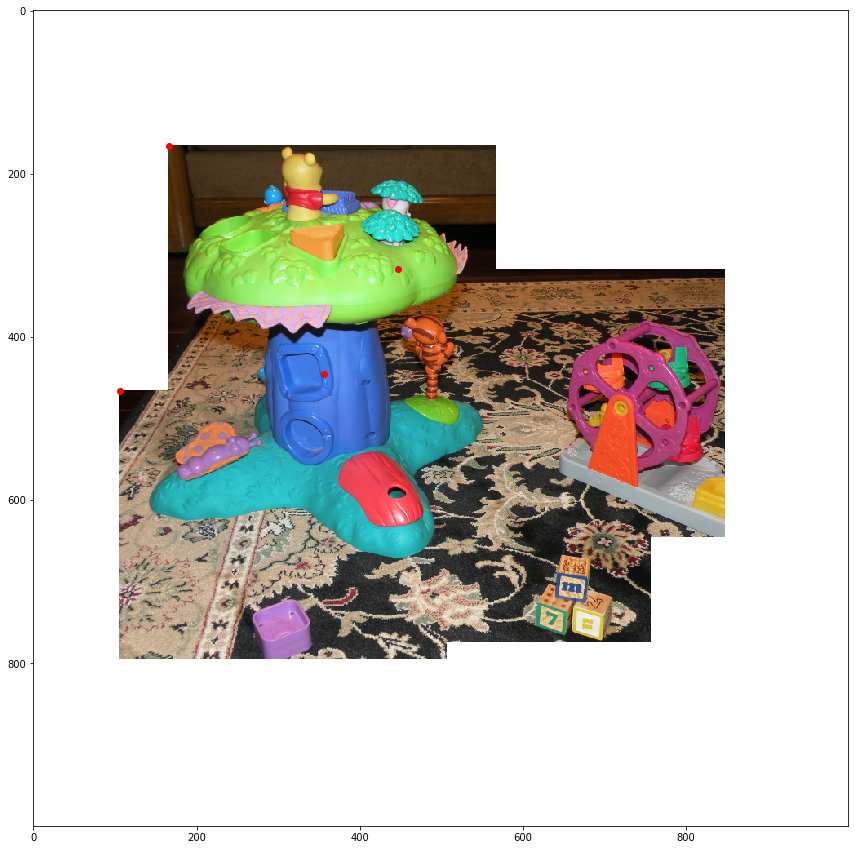

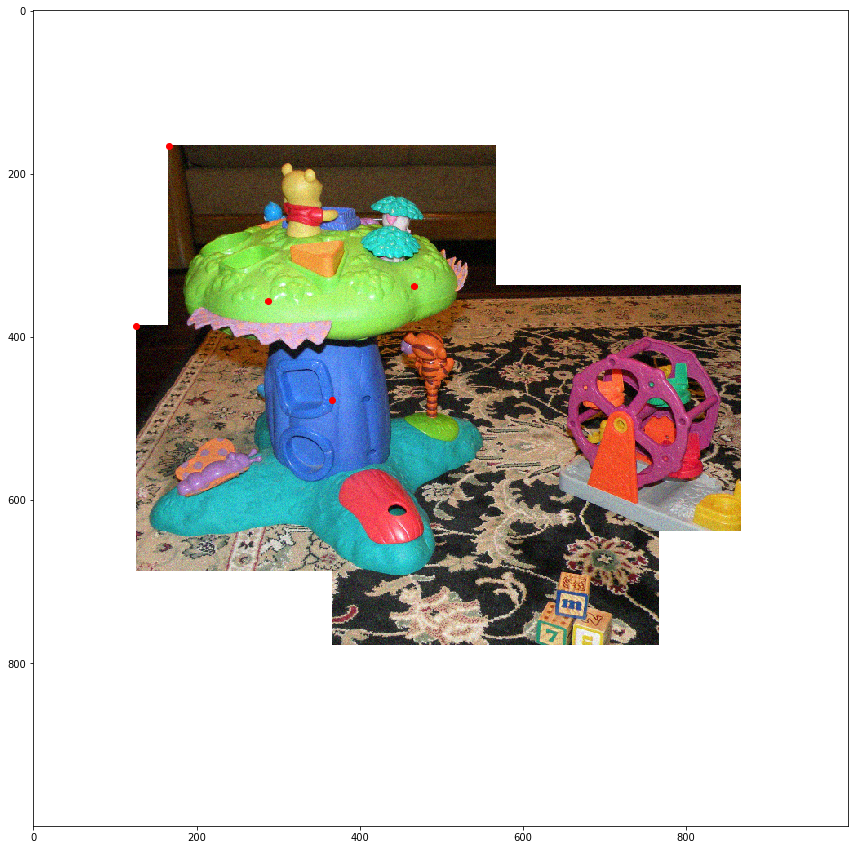

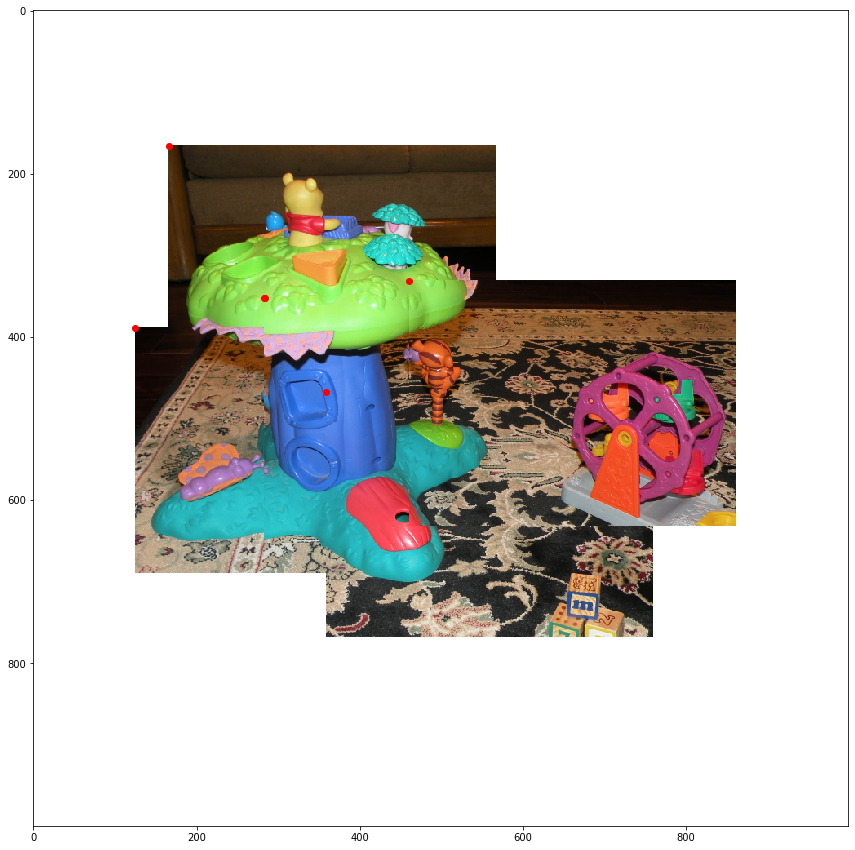

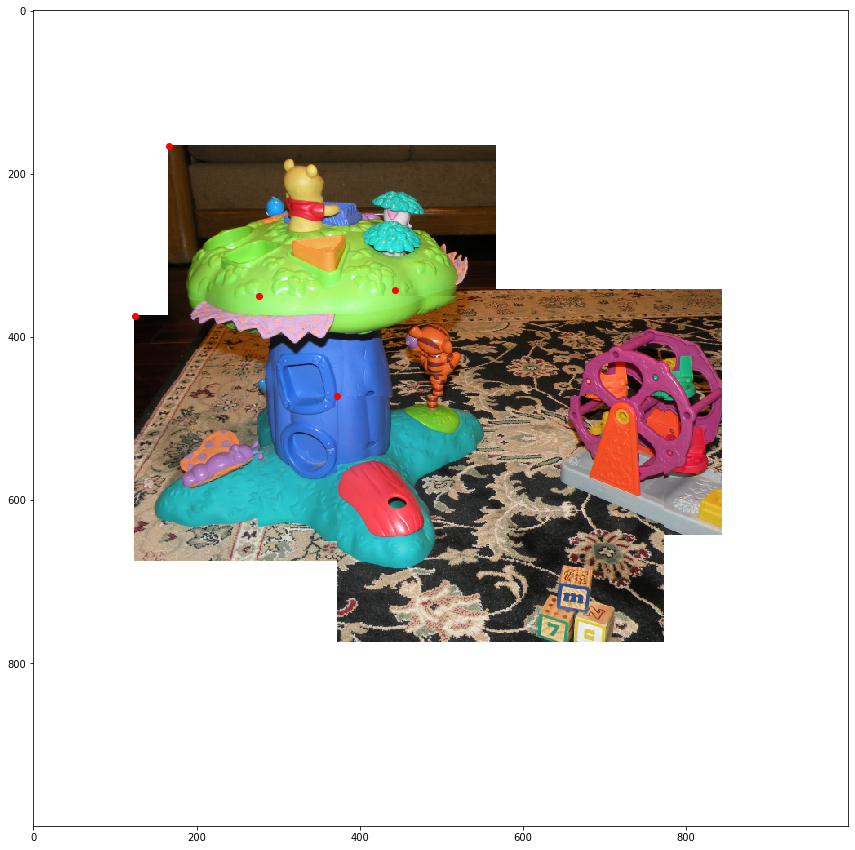

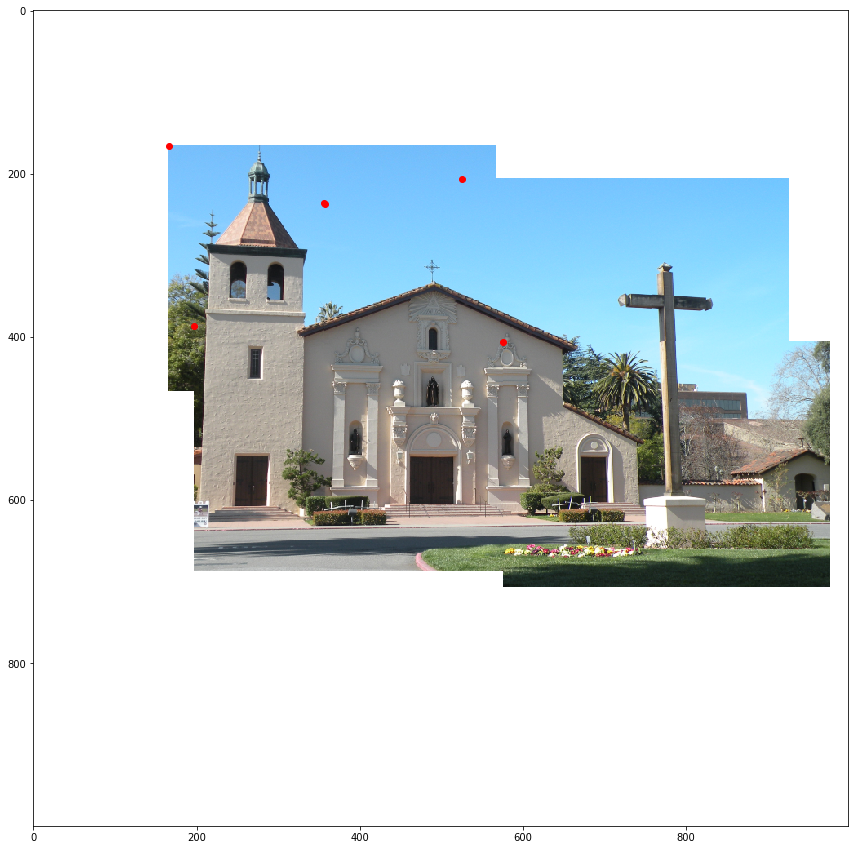

In [18]:
for tableIdx, tableDF in enumerate(imgTemplateTable):
    imgdict = {}
    for imgIdx,imgName in enumerate(tableDF.index): 
        imgdict[imgName] = {}  

        imgdict[imgName]['merged'] = False
        imgdict[imgName]['img'] = allImgs[imgName]

    plt.figure(figsize=(15,15))

    nSz = 1000
    finalImage = np.ones((nSz,nSz,3)).astype(int) * 255

    
    
    for templateIdx,templateName in enumerate(tableDF.columns):
#         print("Merging: {} -> {}".format(templateName[-2],templateName[-1]))
#         print("{} lives in {} @ point: {}".format(templateName,templateName[-2],tableDF[templateName][templateName[-2]]))
#         print("{} lives in {} @ point: {}".format(templateName,templateName[-1],tableDF[templateName][templateName[-1]]))
#         print()

        firstImage = templateName[-2]
        secondImage = templateName[-1]
        
        if scoreTables[tableIdx][templateName][firstImage] == 'Inf' or scoreTables[tableIdx][templateName][firstImage] == 'Inf':
            continue
        
#         print("Score for template: {} for img: {}".format(templateName,firstImage))
#         print(scoreTables[tableIdx][templateName][firstImage])
#         print("Score for template: {} for img: {}".format(templateName,secondImage))
#         print(scoreTables[tableIdx][templateName][secondImage])
#         print(scoreTables[tableIdx][templateName])
        
        if isFirstMerge(imgdict):
            x0 = nSz//6
            y0 = nSz//6

            xLC = 0 # x Left Corner
            yLC = 0 # y Left Corner

            tW = imgdict[firstImage]['img'].shape[0]
            tH = imgdict[firstImage]['img'].shape[1]

            imgdict[firstImage]['xStart'] = x0+xLC
            xEnd = imgdict[firstImage]['xStart']+tW
            imgdict[firstImage]['yStart'] = y0+yLC
            yEnd = imgdict[firstImage]['yStart']+tH

            finalImage[imgdict[firstImage]['xStart']:xEnd,imgdict[firstImage]['yStart']:yEnd,:] = imgdict[firstImage]['img']

            plt.plot(imgdict[firstImage]['yStart'],imgdict[firstImage]['xStart'],'ro')
          
        if 'xStart' not in imgdict[firstImage]:
            tmp = secondImage
            secondImage = firstImage
            firstImage = tmp

        # MERGE NEW IMAGE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  
        x0 = imgdict[firstImage]['xStart']
        y0 = imgdict[firstImage]['yStart']

        xLC = tableDF[templateName][firstImage][0] - tableDF[templateName][secondImage][0] # x Left Corner
        yLC = tableDF[templateName][firstImage][1] - tableDF[templateName][secondImage][1] # y Left Corner

        tW = imgdict[secondImage]['img'].shape[0]
        tH = imgdict[secondImage]['img'].shape[1]

        imgdict[secondImage]['xStart'] = x0+xLC
        xEnd = imgdict[secondImage]['xStart']+tW
        imgdict[secondImage]['yStart'] = y0+yLC
        yEnd = imgdict[secondImage]['yStart']+tH

        finalImage[imgdict[secondImage]['xStart']:xEnd,imgdict[secondImage]['yStart']:yEnd,:] = imgdict[secondImage]['img']

        plt.plot(imgdict[secondImage]['yStart'],imgdict[secondImage]['xStart'],'ro')

        # IMAGE "A" MERGED...
        plt.imshow(finalImage)


        imgdict[firstImage]['merged'] = True
        imgdict[secondImage]['merged'] = True

        if stopMerge(imgdict):
            break 
            plt.show()
            